In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install spectral

     |████████████████████████████████| 212 kB 10.6 MB/s 


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, concatenate, Concatenate, SeparableConv2D, DepthwiseConv2D
from keras.layers import Dropout, Input, ZeroPadding3D, Activation, AveragePooling3D, MaxPooling3D, GlobalMaxPooling2D, Add, GlobalAveragePooling3D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras import models
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.initializers import glorot_uniform

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from spectral import spy_colors
import scipy.io as sio
import os
import spectral
import time
init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.8
windowSize = 11

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive/data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'B':
        data = sio.loadmat(os.path.join(data_path, 'Botswana.mat'))['Botswana']
        labels = sio.loadmat(os.path.join(data_path, 'Botswana_gt.mat'))['Botswana_gt']
    
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
# # data Loading
XX, y = loadData(dataset)
XX= ((XX-np.mean(XX))/np.std(XX))
# print(XX)
XX.shape, y.shape


((145, 145, 200), (145, 145))

In [ ]:
K = XX.shape[2]
XX.shape[2]

200

In [ ]:
K = 30
XX,pca = applyPCA(XX,numComponents=K)

XX.shape

(145, 145, 30)

In [ ]:
XX, y = createImageCubes(XX, y, windowSize=windowSize)

XX.shape, y.shape

((10249, 11, 11, 30), (10249,))

In [ ]:
# Training and testing patches spitining
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(XX, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2049, 11, 11, 30), (8200, 11, 11, 30), (2049,), (8200,))

In [ ]:
#train data reshape
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2049, 11, 11, 30, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(2049, 16)

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
# def _depthwise_conv_block(inputs, pointwise_conv_filters, strides=(1, 1), block_id=222):

#     channel_axis = 3
#     if strides == (1, 1):
#         x = inputs
#     else:
#         x = layers.ZeroPadding2D(((0, 1), (0, 1)),
#                                  name='conv_pad_%d' % block_id)(inputs)
#     x = layers.DepthwiseConv2D((3, 3),
#                                padding='same' if strides == (1, 1) else 'valid',
#                                strides=strides,
#                                use_bias=False,
#                                name='conv_dw_%d' % block_id)(x)
#     # x = layers.BatchNormalization(
#     #     axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
#     # x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

#     x = layers.Conv2D(pointwise_conv_filters, (1, 1),
#                       padding='same',
#                       use_bias=False,
#                       strides=(1, 1),
#                       name='conv_pw_%d' % block_id)(x)
#     # x = layers.BatchNormalization(axis=channel_axis,
#     #                               name='conv_pw_%d_bn' % block_id)(x)
#     return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

In [ ]:
# def model(input_shape,classes=2,activation='softmax',use_batchnorm=True):

#     img_input = layers.Input(shape=input_shape)

#     x = _conv_block(img_input, 32, strides=(2, 2))
#     # x = _depthwise_conv_block(img_input, 32, strides=(2, 2))

#     skip1 = _depthwise_conv_block(x, 32, block_id=1)

#     x = _depthwise_conv_block(skip1, 64, strides=(2, 2), block_id=2)
#     skip2 = _depthwise_conv_block(x, 64, block_id=3)

#     x = _depthwise_conv_block(skip2, 128,strides=(2, 2), block_id=4)
#     skip3 = _depthwise_conv_block(x, 128, block_id=5)

#     x = _depthwise_conv_block(skip3, 256,strides=(2, 2), block_id=6)
#     skip4 = _depthwise_conv_block(x, 256, block_id=7)

#     x = _depthwise_conv_block(skip4, 512, strides=(2, 2), block_id=12)
#     x = _depthwise_conv_block(x, 512,block_id=13)

In [ ]:
def DepthModel():
  inputA=Input((11,11,30,1))
  
  model_con = Conv3D(filters=32, kernel_size=(3,3,7), activation='relu')(inputA)
  model_con = Conv3D(filters=64, kernel_size=(3,3,3), activation='relu')(model_con)
  model_con = Conv3D(filters=64, kernel_size=(1,1,1), activation='relu')(model_con)

  model_con_shape = model_con.shape
  model_con = Reshape((model_con_shape [1], model_con_shape [2], model_con_shape [3]*model_con_shape[4]))(model_con)

  x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(model_con)

  # x = _depthwise_conv_block(x, 128, strides=(2, 2), block_id=1)
  # x = _depthwise_conv_block(x, 128, strides=(2, 2), block_id=2)
  x= SeparableConv2D(128, (3, 3), activation='relu', padding= "same")(x)

  x = Conv2D(filters=128, kernel_size=(1,1), activation='relu')(x)


  # tower_1= SeparableConv2D(32, (3, 3), activation='relu', padding= "same")(model_con)
  # tower_1_1 = MaxPooling2D((3, 3), strides=2, padding='same')(tower_1)

  # tower_2= SeparableConv2D(64, (3, 3), activation='relu', padding= "same")(tower_1_1)
  # tower_2_1 = MaxPooling2D((3, 3), strides=2, padding='same')(tower_2)

  # tower_3= SeparableConv2D(128, (3, 3), activation='relu', padding= "same")(tower_2_1)
  # tower_3_1 = MaxPooling2D((3, 3), strides=2, padding='same')(tower_3)

  flatten_layer = Flatten()(x)
  # ## fully connected layers
  
  dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(0.4)(dense_layer1)
  dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(0.4)(dense_layer2)
  output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

  model = keras.Model(inputs= inputA, outputs= output_layer)
  return model


In [ ]:
model= DepthModel()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11, 11, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 9, 9, 24, 32)      2048      
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 7, 22, 64)      55360     
                                                                 
 conv3d_2 (Conv3D)           (None, 7, 7, 22, 64)      4160      
                                                                 
 reshape (Reshape)           (None, 7, 7, 1408)        0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 128)         1622144   
                                                                 
 separable_conv2d (Separable  (None, 5, 5, 128)        17664 

In [ ]:
# checkpoint
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/DepthwiseSeparableConvolution/IP/IP2/best-model.hdf5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')
# earlyStopping=  EarlyStopping(monitor='accuracy', patience=20, verbose=1, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model= DepthModel()
  # compiling the model
  adam = Adam(learning_rate=0.001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  

In [ ]:
model= DepthModel()
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

start = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

end = time.time()
# cnn_mnist_time = end-start
# print("Total training time is {:0.2f} minute".format(cnn_mnist_time/60.0))
print(end - start)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 2.6708 - accuracy: 0.1703
Epoch 00001: accuracy improved from -inf to 0.17033, saving model to /content/drive/MyDrive/Colab Notebooks/DepthwiseSeparableConvolution/IP/IP2/best-model.hdf5
9/9 [==============================] - 14s 280ms/step - loss: 2.6708 - accuracy: 0.1703
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 2.5355 - accuracy: 0.1592
Epoch 00002: accuracy did not improve from 0.17033
9/9 [==============================] - 2s 229ms/step - loss: 2.5357 - accuracy: 0.1591
Epoch 3/100
8/9 [=========================>....] - ETA: 0s - loss: 2.4760 - accuracy: 0.2119
Epoch 00003: accuracy improved from 0.17033 to 0.21230, saving model to /content/drive/MyDrive/Colab Notebooks/DepthwiseSeparableConvolution/IP/IP2/best-model.hdf5
9/9 [==============================] - 2s 256ms/step - loss: 2.4753 - accuracy: 0.2123
Epoch 4/100
8/9 [=========================>....] - ETA: 0s - loss: 2.3739 - accurac

In [ ]:
tot_time=end-start
print("Total Elapsed Runtime:",str(int((tot_time/3600)))+":"+str(int((tot_time%3600)/60))+":"+str(int((tot_time%3600)%60)) )

Total Elapsed Runtime: 0:3:51


In [ ]:
# load best weights
model.load_weights("/content/drive/MyDrive/Colab Notebooks/DepthwiseSeparableConvolution/IP/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(8200, 11, 11, 30, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(8200, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.99      0.99      0.99      1143
           2       1.00      0.98      0.99       664
           3       0.95      1.00      0.98       190
           4       1.00      0.99      0.99       386
           5       1.00      1.00      1.00       584
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00       382
           8       1.00      1.00      1.00        16
           9       0.99      0.99      0.99       778
          10       0.99      1.00      0.99      1964
          11       0.99      0.99      0.99       475
          12       1.00      1.00      1.00       164
          13       1.00      1.00      1.00      1012
          14       1.00      1.00      1.00       309
          15       0.99      0.99      0.99        74

    accuracy                           0.99      8200
   macro avg       0.99   

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'B':
        target_names = ['Water','Hippo grass','Floodplain grasses 1','Floodplain grasses 2', 'Reeds','Riparian','Fire scar',
                        'Island interior','Acacia woodlands', 'Acacia shrublands', 'Acacia grasslands', 'Short mopane', 'Mixed mopane', 'Exposed soils']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/MyDrive/Colab Notebooks/DepthwiseSeparableConvolution/IP/IP2/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

257/257 [==============================] - 5s 20ms/step - loss: 0.0450 - accuracy: 0.9932


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
XX, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
XX,pca = applyPCA(XX, numComponents=numComponents)

In [ ]:
XX = padWithZeros(XX, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(XX,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

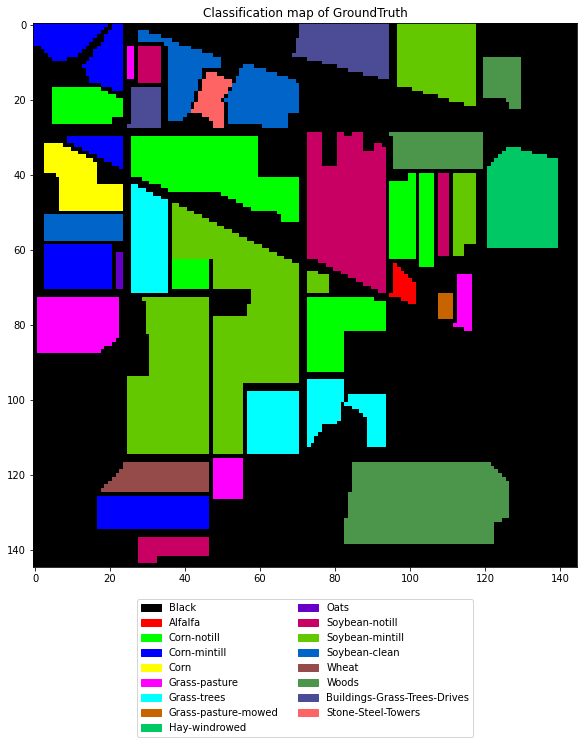

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(10,10))
plt.title('Classification map of GroundTruth')

if dataset == 'IP':
  labelDictionary= {1:'Alfalfa', 2:'Corn-notill', 3:'Corn-mintill', 4:'Corn',
                    5:'Grass-pasture', 6:'Grass-trees', 7:'Grass-pasture-mowed', 
                    8:'Hay-windrowed', 9:'Oats', 10:'Soybean-notill', 11:'Soybean-mintill',
                    12:'Soybean-clean', 13:'Wheat', 14:'Woods', 15:'Buildings-Grass-Trees-Drives',
                    16:'Stone-Steel-Towers', 0:'Black'}
elif dataset == 'SA':
  labelDictionary = {1:'Brocoli_green_weeds_1', 2:'Brocoli_green_weeds_2', 3:'Fallow', 4:'Fallow_rough_plow', 5:'Fallow_smooth',
                     6:'Stubble', 7:'Celery', 8:'Grapes_untrained', 9:'Soil_vinyard_develop', 10:'Corn_senesced_green_weeds',
                    11:'Lettuce_romaine_4wk', 12:'Lettuce_romaine_5wk', 13:'Lettuce_romaine_6wk', 14:'Lettuce_romaine_7wk',
                    15:'Vinyard_untrained', 16:'Vinyard_vertical_trellis', 0:'Black'}
elif dataset == 'PU':
  labelDictionary = {1:'Asphalt', 2:'Meadows', 3:'Gravel', 4:'Trees', 5:'Painted metal sheets', 6:'Bare Soil', 7:'Bitumen',
                      8:'Self-Blocking Bricks', 9:'Shadows', 0:'Black'}

labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=labelDictionary[x]) for x in np.unique(y) ]

plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(10,10))
plt.title('Predicted Classification map 3DCNN')
plt.legend(handles=labelPatches,ncol=2, fontsize='medium', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05))

In [ ]:
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/HybridCNN/Ornek-IP/predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("/content/drive/MyDrive/Colab Notebooks/HybridCNN/Ornek-IP/ground truth.jpg", y, colors=spectral.spy_colors)

In [ ]:
f = open("/content/drive/MyDrive/Colab Notebooks/HybridCNN/Ornek-IP/classification_report.txt", "r")
print(f.read())

In [ ]:
import pandas as pd
import seaborn as sn

names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']

Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)


mat = confusion_matrix(np.argmax(ytest, axis=1), y_pred)

df_cm = pd.DataFrame(mat, columns=names, index = names)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,7))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}, fmt='d')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/HybridCNN/Ornek-IP/cmap.png', dpi=300)